Subpath Patching



In [24]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [25]:
import torch

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from transformer_lens import HookedTransformer, HookedTransformerConfig
import transformer_lens.utils as utils

from tree_generation import *
from utils import *
from interp_utils import *
from probing import *
from sparse_coding import *

Load Dataset and Model

In [29]:
n_examples = 300_000
n_states = 16
dataset = GraphDataset(n_states, "dataset.txt", n_examples)

Loading contents from file...


In [ ]:
cfg = HookedTransformerConfig(
    n_layers=6,
    d_model=128,
    n_ctx=dataset.max_seq_length - 1,
    n_heads=1,
    d_mlp=512,
    d_head=128,
    #attn_only=True,
    d_vocab=len(dataset.idx2tokens),
    device="cuda",
    attention_dir= "causal",
    act_fn="gelu",
)
model = HookedTransformer(cfg)
model.load_state_dict(torch.load("model.pt"))

<All keys matched successfully>

4>10,4>5,14>4,14>1,13>14,3>7,2>13,2>9,6>11,0>3,0>2,15>6,15>0,12>15,8>12|1:8>12>15>0>2>13>14>1


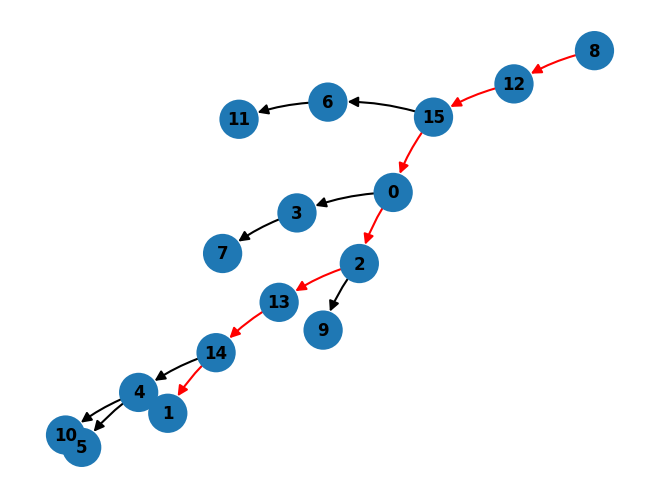

In [104]:
import random

#random_seed = random.randint(400_000, 1_000_000)
test_graph = examples[0]# generate_example(16, random_seed, order="backward", path_length=6)
if is_model_correct(model, dataset, test_graph):
    parse_example(test_graph)
labels, cache = get_example_cache(test_graph, model, dataset)
print(test_graph)

Extract Subpaths

In [105]:
from subpath_utils import extract_subpaths
import importlib
import subpath_utils #import the module here, so that it can be reloaded.
importlib.reload(subpath_utils)

subpaths = extract_subpaths(model, examples[0], cache, labels)
subpaths

{(38, ','): ['10', '4', '14'],
 (39, '12'): ['3', '0', '15'],
 (41, ','): ['2', '0', '15'],
 (44, '|'): ['15', '12', '8'],
 (45, '1'): ['4', '14', '13'],
 (46, ':'): ['14', '13', '2'],
 (47, '8'): ['1', '14', '13']}

In [106]:
examples[0]

'4>10,4>5,14>4,14>1,13>14,3>7,2>13,2>9,6>11,0>3,0>2,15>6,15>0,12>15,8>12|1:8>12>15>0>2>13>14>1'

8>11,8>7,13>8,3>13,3>9,10>3,6>10,2>6,2>1,14>2,12>14,15>12,4>15,0>4,5>0|7:5>0>4>15>12>14>2>6>10>3>13>8>7


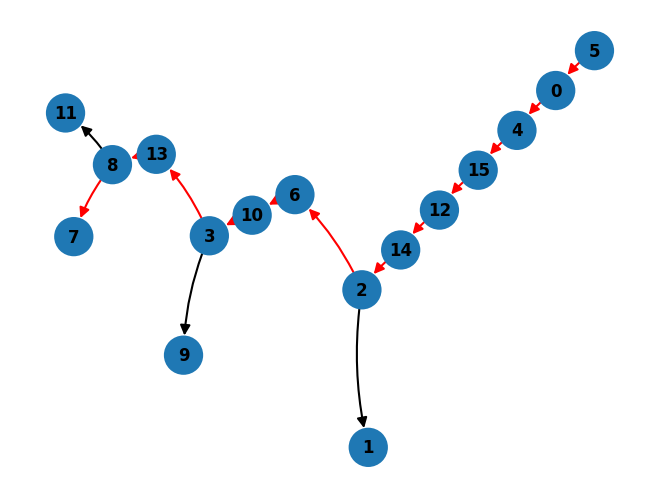

In [72]:
import random

random_seed = random.randint(400_000, 1_000_000)
test_graph = generate_example(16, random_seed, order="backward", path_length=12)
if is_model_correct(model, dataset, test_graph):
    parse_example(test_graph)
labels, cache = get_example_cache(test_graph, model, dataset)
print(test_graph)

from fancy_einsum import einsum
import numpy as np

def apply_causal_mask_and_softmax(matrix):
    # Assuming matrix is a PyTorch tensor of shape (65, 65)
    # Step 1: Create a causal mask
    rows, cols = matrix.size()
    causal_mask = torch.tril(torch.ones(rows, cols, dtype=torch.bool))

    # Step 2: Apply the causal mask
    # Use a very large negative number for masked values
    masked_matrix = matrix.masked_fill(~causal_mask, float('-inf'))
    

    # Step 3: Compute softmax per row
    #softmax_matrix = F.softmax(masked_matrix, dim=1)

    return masked_matrix


for layer in range(model.cfg.n_layers):
    #example_attn_matrix = cache[f"blocks.{layer}.attn.hook_pattern"][0, 0, :, :].cpu()
    with torch.no_grad():
        info_weighting = einsum(
            "head_index d_head d_model, \
                batch pos head_index d_head -> \
                batch pos d_model",
            model.blocks[layer].attn.W_O,
            cache[f"blocks.{layer}.attn.hook_v"],
        )
    attn_patterns = cache[f"blocks.{layer}.attn.hook_pattern"][0, 0, :, :]
    value_weighted_attn = (attn_patterns * info_weighting[0, :, :].norm(dim=1, p=2)).cpu()[:, :]

    value_weighted_attn = apply_causal_mask_and_softmax(value_weighted_attn)


    # value weighted patterns
    fig = px.imshow(
        value_weighted_attn,
        labels=dict(x="Previous Token attended to", y="Correct Next Step", color="Value"),
        color_continuous_scale="Blues",
        zmin=0,
        #zmax=1,
        aspect="auto"
    )

    layout = dict(
        width=1200,
        height=1200,
        xaxis=dict(
            tickmode="array",
            tickvals=np.arange(len(labels)),
            ticktext=labels,
        ),
        yaxis=dict(
            tickmode="array",
            tickvals=np.arange(len(labels)),
            ticktext=labels,
        )
    )
    fig.update_layout(layout)
    fig.show()

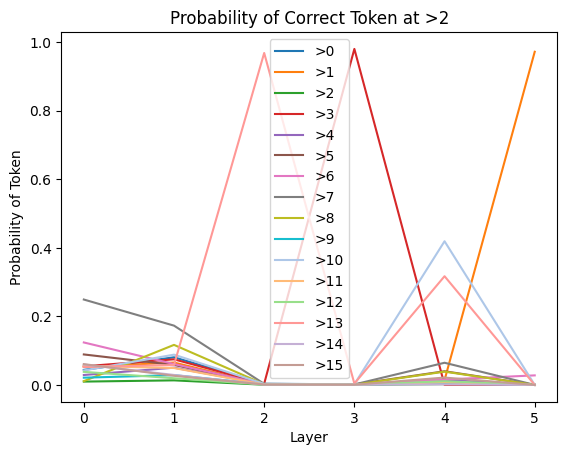

In [88]:
import torch
import os
import matplotlib.colors as mcolors

def get_colormap(n_colors):
    cmap = plt.cm.get_cmap('viridis', n_colors)  # You can choose different colormaps like 'viridis', 'plasma', etc.
    return [cmap(i) for i in range(cmap.N)]

def get_custom_colors():
    return [
        "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
        "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
        "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
        "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5"
    ]

def load_lenses(directory="lenses"):
    lenses = {}
    for filename in os.listdir(directory):
        if filename.endswith(".pt"):
            key = filename[:-3]  # Remove the ".pt" extension
            filepath = os.path.join(directory, filename)
            lenses[key] = torch.load(filepath)
    return lenses

lenses= load_lenses()

def logit_lens_all_probs(pred, model, dataset, position, lenses=None):
    # Get labels and cache
    labels, cache = get_example_cache(pred, model, dataset)
    current_node = int(labels[position].split(">")[-1])
    current_neighbors = [f">{i}" for i in range(dataset.n_states)]
    # Get the logit lens for each layer's resid_post
    probs = {key: [] for key in current_neighbors}
    correct_token = labels[position+1]
    correct_token_idx = dataset.tokens2idx[correct_token]
    for layer in range(1, model.cfg.n_layers+1):
        if layer < model.cfg.n_layers:
            act_name = tl_util.get_act_name("normalized", layer, "ln1")
        else:
            act_name = "ln_final.hook_normalized"
        res_stream = cache[act_name][0]
        if lenses is not None:
            print("computing with lenses")
            out_proj = res_stream @ lenses[act_name]
        else:
            out_proj = res_stream @ model.W_U
        out_proj = out_proj.softmax(-1)
        for key in probs:
            key_prob = out_proj[position, dataset.tokens2idx[key]].item()
            probs[key].append(key_prob)

    # Generate colors
    unique_keys = len(probs)
    colors = get_custom_colors()

    # Plot data with custom colors
    for i, key in enumerate(probs):
        plt.plot(probs[key], label=key, color=colors[i])
    plt.xlabel("Layer")
    plt.ylabel(f"Probability of Token")
    plt.title(f"Probability of Correct Token at {labels[position]}")
    plt.legend()
    plt.show()
    # Return result
    return probs

probs = logit_lens_all_probs(test_graph, model, dataset, 53)

Block the Model from attending to Subpaths (Attention Knockout)

In [96]:
def is_model_correct(model, dataset, test_graph, return_probs=False, add_hooks_fn=None):
    # Prepare model
    model.eval()
    if add_hooks_fn is not None:
        add_hooks_fn(model)

    # Initialize counters
    test_graph_tokens = dataset.tokenize(test_graph)
    start_idx = np.where(test_graph_tokens == dataset.start_token)[0].item() + 1
    end_idx = num_last([dataset.idx2tokens[i] for i in test_graph_tokens], ",")
    input_tokens = torch.from_numpy(test_graph_tokens).to(torch.long).cuda()
    input_tokens = input_tokens.unsqueeze(0)[:, :-1]

    # Run model
    with torch.no_grad():
        probs = model(input_tokens).softmax(-1)
        outputs = probs.argmax(-1)
    correct = torch.all(outputs[:, start_idx:end_idx] == input_tokens[:, start_idx+1:end_idx+1]).item()
    if return_probs:
        return correct, probs
    return correct

In [87]:
def add_attention_blockout(model, layer, head, current, attending):

    def attention_score_hook_edges(resid_pre, hook, r, c):
        resid_pre[:, head, r, c] = 0
        return resid_pre

    temp_hook_fn = partial(attention_score_hook_edges, r=current, c=attending)
    model.blocks[layer].attn.hook_pattern.add_hook(temp_hook_fn)

model.reset_hooks()
print(is_model_correct(model, dataset, test_graph))

model.reset_hooks()
for cur_pos in range(47, 55):
    for att_pos in [36, 38, 39, 41, 42, 44, 45, 46]:
        add_attention_blockout(model, 3, 0, cur_pos, att_pos)
        add_attention_blockout(model, 4, 0, cur_pos, att_pos)
        add_attention_blockout(model, 5, 0, cur_pos, att_pos)

print(is_model_correct(model, dataset, test_graph))

>0>4>15>12>14>2>6>10>3>13>8>7
>0>4>15>12>14>2>6>10>3>13>8>7
True
>0>4>15>12>14>2>1>10>3>13>8>7
>0>4>15>12>14>2>6>10>3>13>8>7
False


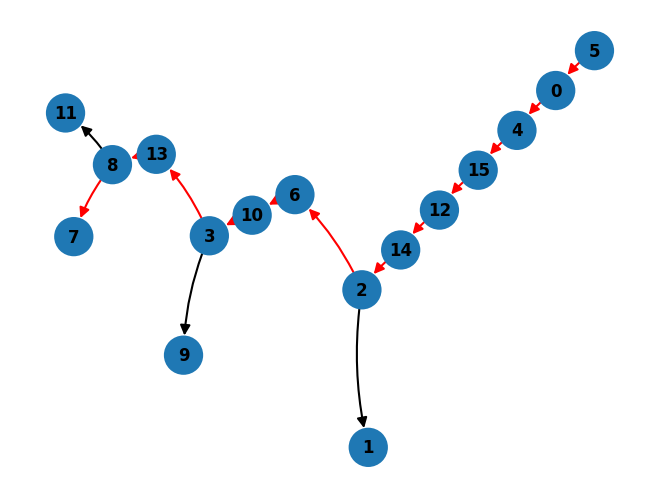

In [79]:
parse_example(test_graph)

Automatic Attention Knockout

In [94]:
# generate example, return all leafs
examples = generate_example(16, 1, "backward", return_all_leafs=True)
examples

['4>10,4>5,14>4,14>1,13>14,3>7,2>13,2>9,6>11,0>3,0>2,15>6,15>0,12>15,8>12|1:8>12>15>0>2>13>14>1',
 '4>10,4>5,14>4,14>1,13>14,3>7,2>13,2>9,6>11,0>3,0>2,15>6,15>0,12>15,8>12|5:8>12>15>0>2>13>14>4>5',
 '4>10,4>5,14>4,14>1,13>14,3>7,2>13,2>9,6>11,0>3,0>2,15>6,15>0,12>15,8>12|7:8>12>15>0>3>7',
 '4>10,4>5,14>4,14>1,13>14,3>7,2>13,2>9,6>11,0>3,0>2,15>6,15>0,12>15,8>12|9:8>12>15>0>2>9',
 '4>10,4>5,14>4,14>1,13>14,3>7,2>13,2>9,6>11,0>3,0>2,15>6,15>0,12>15,8>12|10:8>12>15>0>2>13>14>4>10',
 '4>10,4>5,14>4,14>1,13>14,3>7,2>13,2>9,6>11,0>3,0>2,15>6,15>0,12>15,8>12|11:8>12>15>6>11']

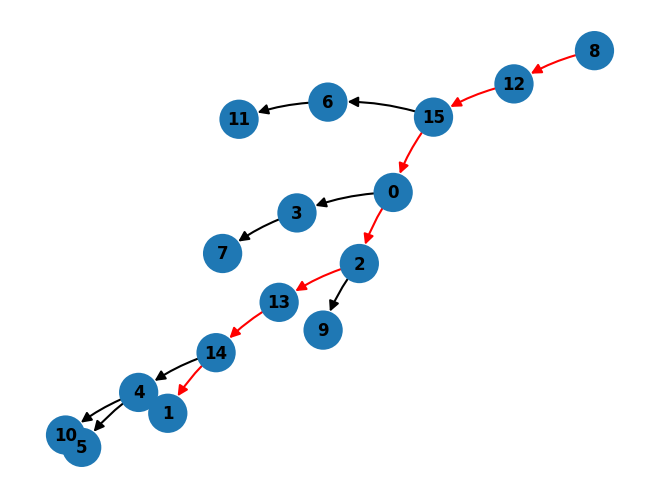

In [93]:
parse_example(examples[0])

In [108]:
from tqdm import tqdm

def attention_knockout_discovery_multiple(model, dataset, multiple_test_graphs):
    # Iterate over heads in each layer
    ablated_edges = {i: [] for i in range(model.cfg.n_layers)}
    important_edges = {i: [] for i in range(model.cfg.n_layers)}
    for l in range(model.cfg.n_layers-1, -1, -1):
        for h in range(model.cfg.n_heads):
            # Check if we can remove attention edges without affecting the correctness of the output
            for i in tqdm(range(model.cfg.n_ctx), desc="n_ctx"):
                for j in range(i, -1, -1):
                    model.reset_hooks()                  
                    # Add already ablated edges
                    for L in ablated_edges.keys():
                        inds = ablated_edges[L]
                        if len(inds) == 0:
                            continue
                        add_attention_blockout_parallel(model, L, inds)
                    # Block new edge
                    add_attention_blockout(model, l, h, i, j)
                    # Check if ablations allow the model to get the correct input on all of the graphs
                    all_correct = True
                    for test_graph in multiple_test_graphs:
                        correct = is_model_correct(model, dataset, test_graph)
                        if not correct:
                            all_correct = False
                    # If correct, add it to the ablations list
                    if all_correct:
                        ablated_edges[l].append((h, i, j))
                    else:
                        important_edges[l].append((h, i, j))
                        print(f"Breaking: Layer {l} head {h}, labels[{i}] attending to labels[{j}]")
    return ablated_edges, important_edges

ablated_edges, important_edges = attention_knockout_discovery_multiple(model, dataset, examples)

n_ctx:  72%|███████▏  | 47/65 [01:03<00:45,  2.52s/it]

Breaking: Layer 5 head 0, labels[47] attending to labels[40]
Breaking: Layer 5 head 0, labels[47] attending to labels[37]
Breaking: Layer 5 head 0, labels[47] attending to labels[19]
Breaking: Layer 5 head 0, labels[47] attending to labels[8]
Breaking: Layer 5 head 0, labels[47] attending to labels[7]
Breaking: Layer 5 head 0, labels[47] attending to labels[6]
Breaking: Layer 5 head 0, labels[47] attending to labels[5]
Breaking: Layer 5 head 0, labels[47] attending to labels[4]
Breaking: Layer 5 head 0, labels[47] attending to labels[3]
Breaking: Layer 5 head 0, labels[47] attending to labels[2]
Breaking: Layer 5 head 0, labels[47] attending to labels[1]


n_ctx:  74%|███████▍  | 48/65 [01:05<00:44,  2.60s/it]

Breaking: Layer 5 head 0, labels[47] attending to labels[0]
Breaking: Layer 5 head 0, labels[48] attending to labels[37]
Breaking: Layer 5 head 0, labels[48] attending to labels[28]
Breaking: Layer 5 head 0, labels[48] attending to labels[25]
Breaking: Layer 5 head 0, labels[48] attending to labels[13]
Breaking: Layer 5 head 0, labels[48] attending to labels[10]
Breaking: Layer 5 head 0, labels[48] attending to labels[7]
Breaking: Layer 5 head 0, labels[48] attending to labels[4]


n_ctx:  75%|███████▌  | 49/65 [01:08<00:42,  2.66s/it]

Breaking: Layer 5 head 0, labels[48] attending to labels[0]


n_ctx:   3%|▎         | 2/65 [00:00<00:05, 11.69it/s]

Breaking: Layer 4 head 0, labels[1] attending to labels[1]


n_ctx:   6%|▌         | 4/65 [00:00<00:09,  6.53it/s]

Breaking: Layer 4 head 0, labels[4] attending to labels[4]
Breaking: Layer 4 head 0, labels[4] attending to labels[2]
Breaking: Layer 4 head 0, labels[4] attending to labels[1]


n_ctx:  11%|█         | 7/65 [00:01<00:16,  3.44it/s]

Breaking: Layer 4 head 0, labels[7] attending to labels[7]


n_ctx:  12%|█▏        | 8/65 [00:02<00:19,  2.90it/s]

Breaking: Layer 4 head 0, labels[7] attending to labels[2]
Breaking: Layer 4 head 0, labels[7] attending to labels[1]
Breaking: Layer 4 head 0, labels[7] attending to labels[0]
Breaking: Layer 4 head 0, labels[8] attending to labels[7]


n_ctx:  14%|█▍        | 9/65 [00:02<00:22,  2.51it/s]

Breaking: Layer 4 head 0, labels[8] attending to labels[1]


n_ctx:  62%|██████▏   | 40/65 [00:48<00:55,  2.20s/it]

Breaking: Layer 4 head 0, labels[40] attending to labels[16]
Breaking: Layer 4 head 0, labels[40] attending to labels[13]
Breaking: Layer 4 head 0, labels[40] attending to labels[12]
Breaking: Layer 4 head 0, labels[40] attending to labels[11]
Breaking: Layer 4 head 0, labels[40] attending to labels[7]
Breaking: Layer 4 head 0, labels[40] attending to labels[6]
Breaking: Layer 4 head 0, labels[40] attending to labels[5]


n_ctx:  63%|██████▎   | 41/65 [00:51<00:54,  2.27s/it]

Breaking: Layer 4 head 0, labels[40] attending to labels[1]
Breaking: Layer 4 head 0, labels[40] attending to labels[0]


n_ctx:  71%|███████   | 46/65 [01:03<00:49,  2.58s/it]

Breaking: Layer 4 head 0, labels[46] attending to labels[37]


n_ctx:  72%|███████▏  | 47/65 [01:06<00:47,  2.64s/it]

Breaking: Layer 4 head 0, labels[47] attending to labels[41]
Breaking: Layer 4 head 0, labels[47] attending to labels[40]
Breaking: Layer 4 head 0, labels[47] attending to labels[31]
Breaking: Layer 4 head 0, labels[47] attending to labels[28]


n_ctx:  74%|███████▍  | 48/65 [01:09<00:45,  2.70s/it]

Breaking: Layer 4 head 0, labels[48] attending to labels[41]
Breaking: Layer 4 head 0, labels[48] attending to labels[34]
Breaking: Layer 4 head 0, labels[48] attending to labels[31]
Breaking: Layer 4 head 0, labels[48] attending to labels[19]


n_ctx:  75%|███████▌  | 49/65 [01:12<00:43,  2.75s/it]

Breaking: Layer 4 head 0, labels[49] attending to labels[31]
Breaking: Layer 4 head 0, labels[49] attending to labels[28]
Breaking: Layer 4 head 0, labels[49] attending to labels[19]


n_ctx:  77%|███████▋  | 50/65 [01:15<00:42,  2.80s/it]

Breaking: Layer 4 head 0, labels[50] attending to labels[19]


n_ctx:  62%|██████▏   | 40/65 [02:14<03:07,  7.52s/it]

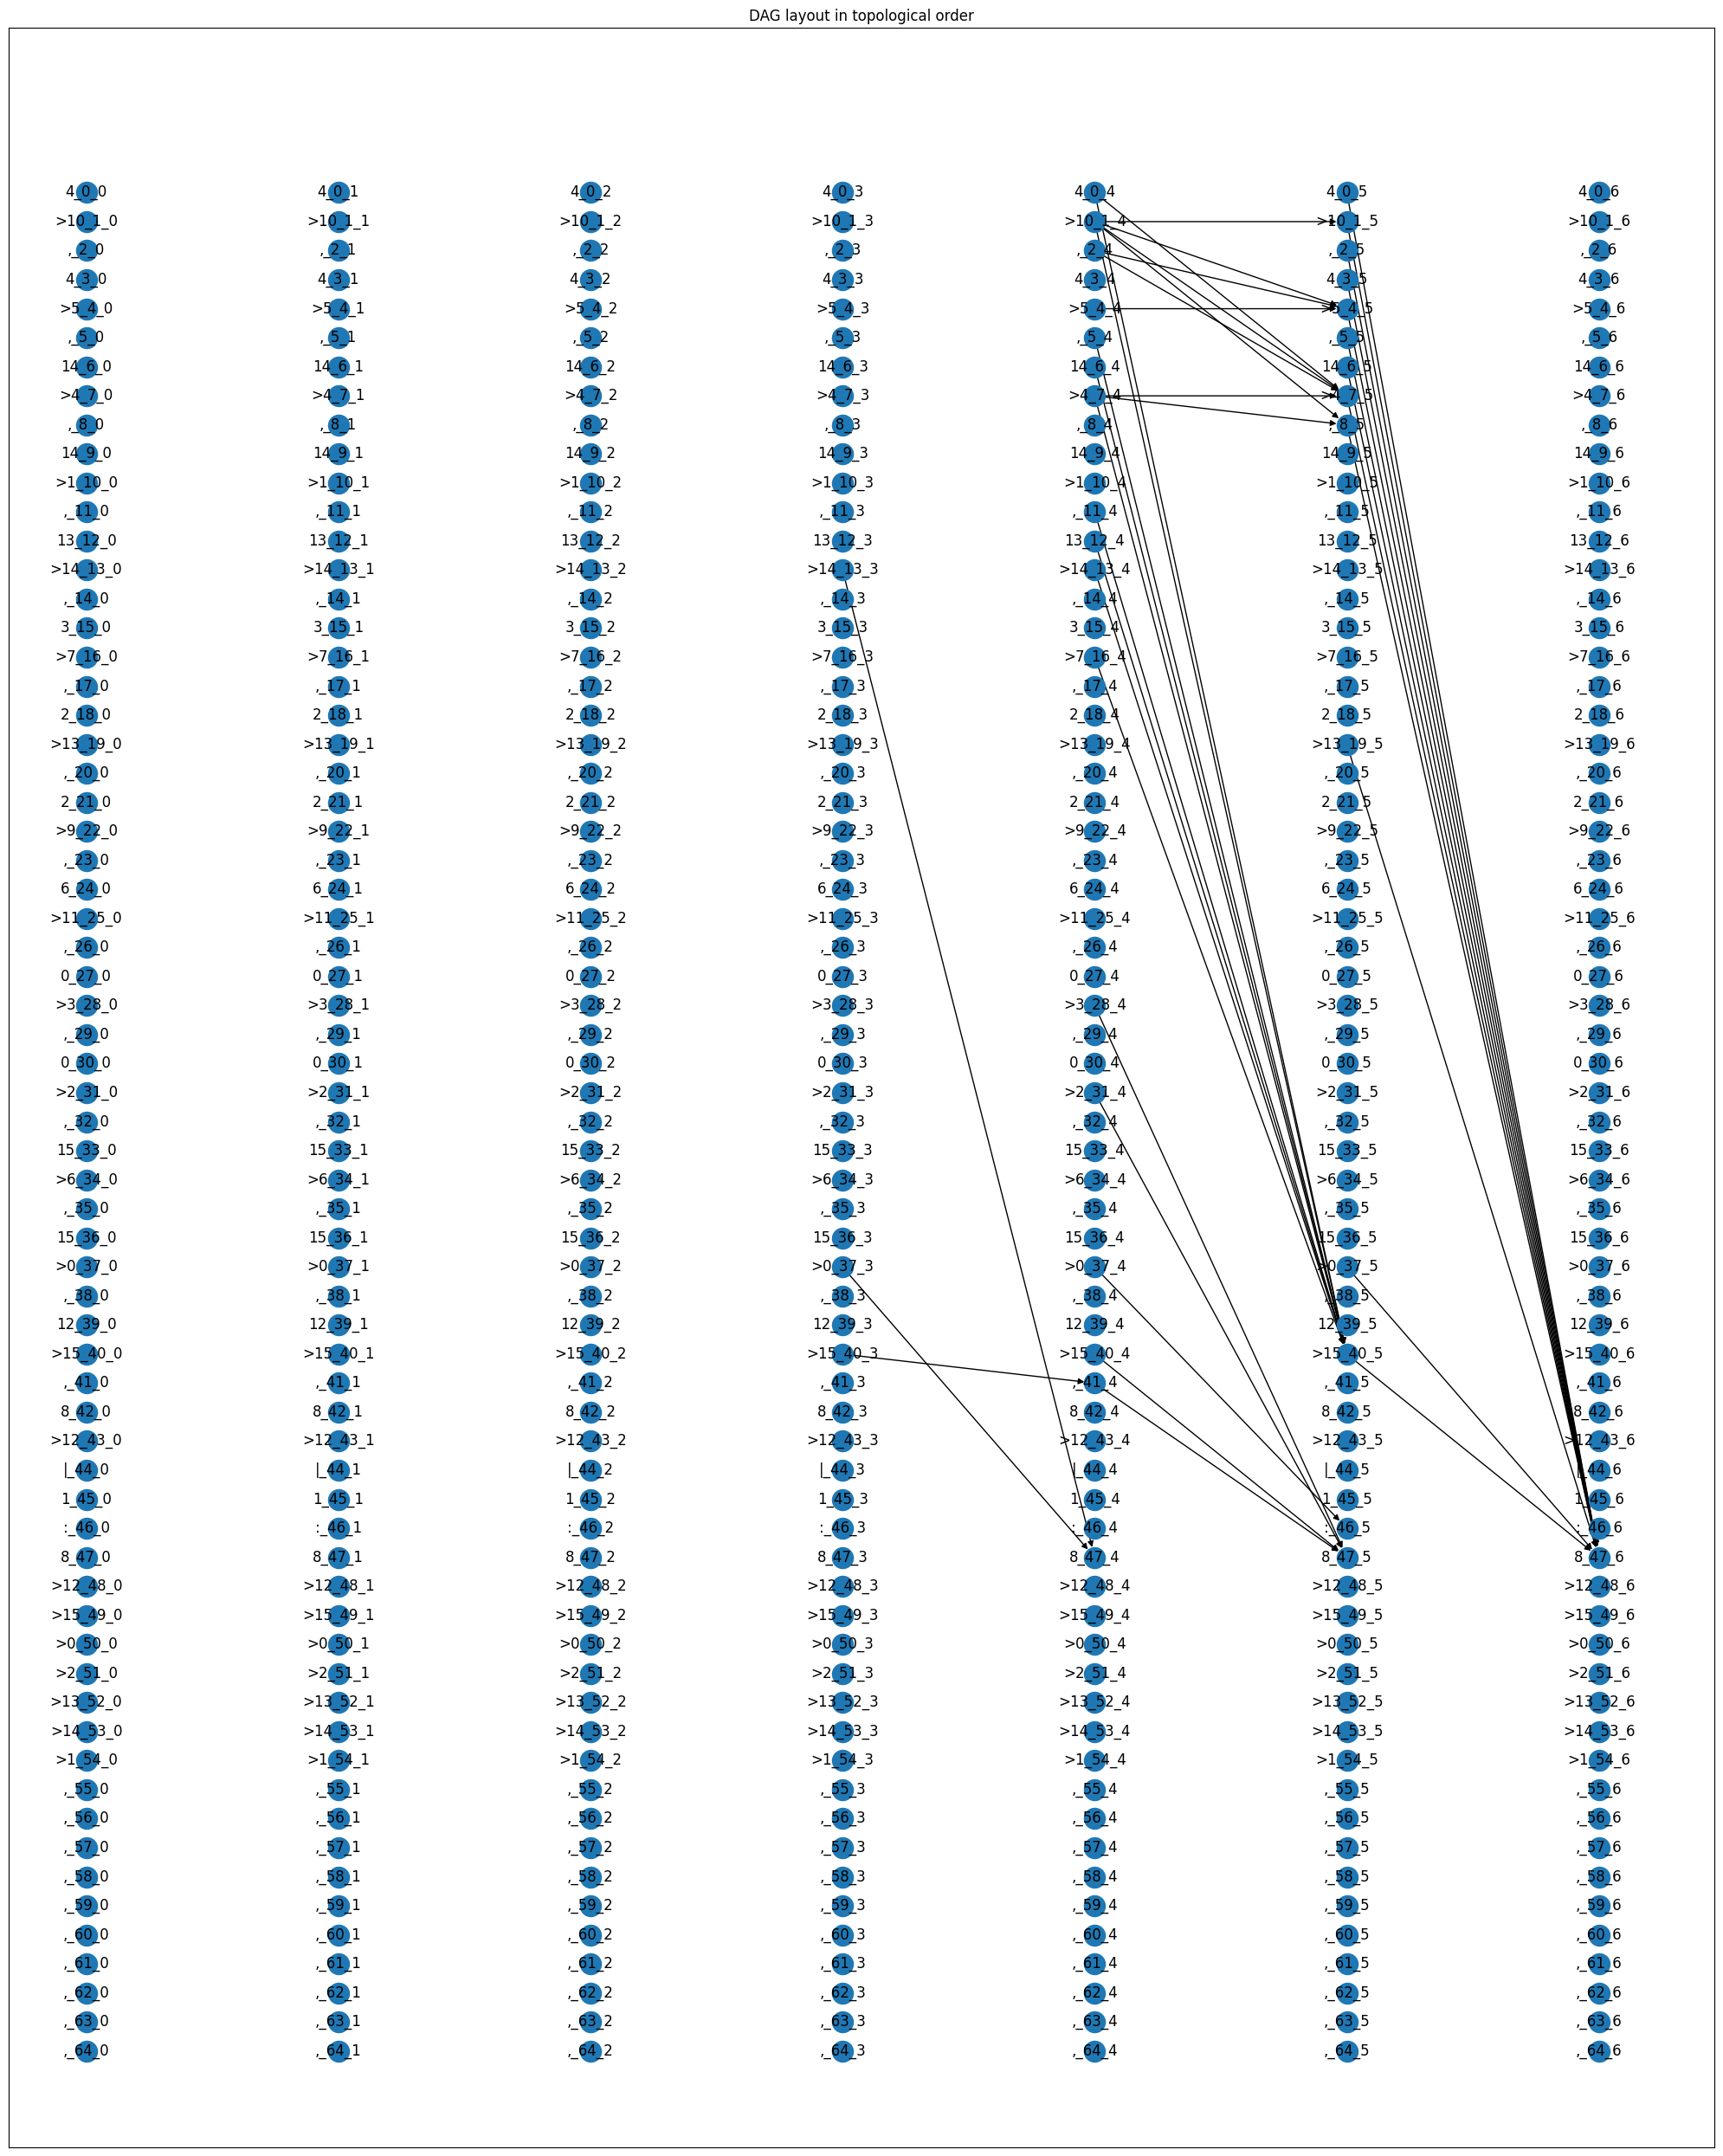

In [107]:
import networkx as nx
G = nx.DiGraph()

for pos, label in enumerate(labels):
    for layer in range(model.cfg.n_layers+1):
        G.add_node(f"{label}_{pos}_{layer}", layer=layer)

for L in important_edges.keys():
    for h, curr, attend in important_edges[L]:
        if curr <= 47:
            G.add_edge(f"{labels[attend]}_{attend}_{L}", f"{labels[curr]}_{curr}_{L+1}")


# Compute the multipartite_layout using the "layer" node attribute
pos = nx.multipartite_layout(G, subset_key="layer")

fig, ax = plt.subplots(figsize=(20, 25))
nx.draw_networkx(G, pos=pos, ax=ax)
ax.set_title("DAG layout in topological order")
fig.tight_layout()
plt.show()